In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

In [2]:
file_path = "/Users/User/Downloads/Fuel used  (Responses).xlsx"
data = pd.read_excel(file_path, sheet_name='Form responses 1') 

print(data.head())

                Timestamp       Date       Car  Fuel Money in (RM)  \
0 2024-12-12 18:42:51.017 2024-12-03   Persona               69.15   
1 2025-01-08 18:01:07.762 2024-12-23   Persona               64.00   
2 2025-01-08 18:02:20.773 2025-01-02  Persona                60.20   

  Previous Driven Distance (KM)  Fuel Used  Fuel Price (RM/L) Petrol Station  
0                             -         95               2.05          Shell  
1                         239.9         95               2.05          Shell  
2                         354.6         95               2.05       Petronas  


In [3]:
data = data.drop(['Timestamp'],axis=1)

In [4]:
categorical_attributes = [
   'Car','Fuel Used','Petrol Station'
]
numerical_attributes = [
    'Litre','KM/L','Fuel Money in (RM)','Time Difference (Days)'
]

In [5]:
# Step 2: Data Preprocessing
# Ensure no missing values in non-predictable columns
data.dropna(subset=['Fuel Money in (RM)', 'Fuel Price (RM/L)'], inplace=True)

# Convert date to datetime
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Add a column for month and year (to group by month)
data['Year-Month'] = data['Date'].dt.to_period('M')

# Turn everything into lowercase
data['Car'] = data['Car'].astype(str).str.lower().str.strip().str.replace(r'\s+', '', regex=True)
data['Fuel Used'] = data['Fuel Used'].astype(str).str.lower()
data['Petrol Station'] = data['Petrol Station'].astype(str).str.lower()

# Convert all values in the 'Previous Driven Distance (KM)' column to numeric, turning errors into NaN
data['Previous Driven Distance (KM)'] = pd.to_numeric(data['Previous Driven Distance (KM)'], errors='coerce').fillna(0)

# Ensure numeric columns are properly formatted
numeric_cols = ['Fuel Money in (RM)', 'Previous Driven Distance (KM)', 'Fuel Price (RM/L)']
data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric, errors='coerce')

In [6]:
# Convert 'Previous Driven Distance (KM)' to numeric, replacing non-numeric values with NaN
data['Previous Driven Distance (KM)'] = pd.to_numeric(
    data['Previous Driven Distance (KM)'], errors='coerce'
)

# Replace NaN with 0 (or handle it as needed)
data['Previous Driven Distance (KM)'] = data['Previous Driven Distance (KM)'].fillna(0)

# Perform the groupby and shift operation
data['Distance'] = (
    data.groupby('Car')['Previous Driven Distance (KM)']
    .shift(-1)
    .fillna(0)
    .astype(float)
)
print(data)

        Date      Car  Fuel Money in (RM)  Previous Driven Distance (KM)  \
0 2024-12-03  persona               69.15                            0.0   
1 2024-12-23  persona               64.00                          239.9   
2 2025-01-02  persona               60.20                          354.6   

  Fuel Used  Fuel Price (RM/L) Petrol Station Year-Month  Distance  
0        95               2.05          shell    2024-12     239.9  
1        95               2.05          shell    2024-12     354.6  
2        95               2.05       petronas    2025-01       0.0  


In [7]:
# Extract the latest fuel price from the data
latest_date = data['Date'].max()  # Find the most recent date
latest_prices = data[data['Date'] == latest_date][['Fuel Used', 'Fuel Price (RM/L)']].drop_duplicates()

# Convert to a dictionary for easy lookup
latest_fuel_prices = dict(zip(latest_prices['Fuel Used'], latest_prices['Fuel Price (RM/L)']))
print("Latest Fuel Prices Based on the Data:")
print(latest_fuel_prices)

Latest Fuel Prices Based on the Data:
{'95': 2.05}


In [8]:
print(data.columns)

Index(['Date', 'Car', 'Fuel Money in (RM)', 'Previous Driven Distance (KM)',
       'Fuel Used', 'Fuel Price (RM/L)', 'Petrol Station', 'Year-Month',
       'Distance'],
      dtype='object')


In [9]:
# Step 3: Feature Engineering for Time Duration and Label Encoding
# Calculate the time difference in days between consecutive rows
data['Time Difference (Days)'] = data['Date'].diff().dt.days.fillna(0)

# Encode car model and fuel used as numerical for KNNImputer
label_encoder_car = LabelEncoder()
label_encoder_fuel = LabelEncoder()
label_encoder_station = LabelEncoder()

data['Car Model Encoded'] = label_encoder_car.fit_transform(data['Car'])
data['Fuel Type Encoded'] = label_encoder_fuel.fit_transform(data['Fuel Used'])
data['Petrol Station Encoded'] = label_encoder_station.fit_transform(data['Petrol Station'])

In [10]:
# Calculate Litre of fuel added in 
data['Litre'] = data['Fuel Money in (RM)'] / data['Fuel Price (RM/L)']
data['KM/L'] = data['Distance']/data['Litre']

In [11]:
# Separate contributions for each fuel type or brand
fuel_efficiency_by_type = data.groupby(['Car', 'Fuel Used']).agg(
    total_distance=('Distance', 'sum'),
    total_fuel=('Litre', 'sum'),
    avg_efficiency=('KM/L', 'mean')
).reset_index()

# Display calculated fuel efficiency
print("Fuel Efficiency by Car and Fuel Type:")
print(fuel_efficiency_by_type)

Fuel Efficiency by Car and Fuel Type:
       Car Fuel Used  total_distance  total_fuel  avg_efficiency
0  persona        95           594.5   94.317073        6.156761


In [12]:
# Create a figure with subplots
#unique_cars = fuel_efficiency_by_type['Car'].unique()
#num_cars = len(unique_cars)

# Set up the subplot grid (1 row, as many columns as cars)
#fig, axes = plt.subplots(1, num_cars, figsize=(15, 6), sharey=True)

# Loop through each car model and plot
#for i, car in enumerate(unique_cars):
    #car_data = fuel_efficiency_by_type[fuel_efficiency_by_type['Car'] == car]
    
    # Create the barplot for this specific car model
    #sns.barplot(data=car_data, x='Fuel Used', y='avg_efficiency', ax=axes[i])
    
    # Set the title and labels for each subplot
   # axes[i].set_title(f'Fuel Efficiency for {car}')
    #axes[i].set_xlabel('Fuel Type')
    #axes[i].set_ylabel('Average Fuel Efficiency (KM/L)')

# Adjust the layout to avoid overlap
#plt.tight_layout()

# Show the plot
#plt.show()//

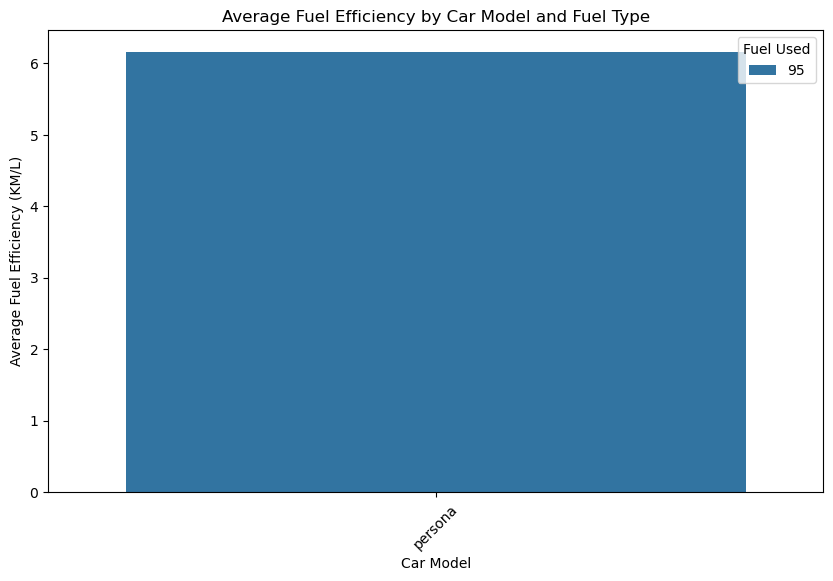

In [13]:
# Create a barplot for average fuel efficiency by car model and fuel type
plt.figure(figsize=(10, 6))
sns.barplot(data=fuel_efficiency_by_type, x='Car', y='avg_efficiency', hue='Fuel Used')

# Set the labels and title
plt.title('Average Fuel Efficiency by Car Model and Fuel Type')
plt.xlabel('Car Model')
plt.ylabel('Average Fuel Efficiency (KM/L)')

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [14]:
# Select relevant features: time difference, car model, fuel type, and fuel used
features = ['Car Model Encoded', 'Fuel Type Encoded', 'Petrol Station Encoded']
target = ['Distance']

# Ensure all columns involved are numeric, replace non-numeric with NaN
data[features + target] = data[features + target].apply(pd.to_numeric, errors='coerce')

# Replace 0 in 'Distance' with np.nan to mark as missing value
data['Distance'] = data['Distance'].replace(0, np.nan)

# Use KNN Imputer to fill in the missing values for "Previous Driven Distance"
imputer = KNNImputer(n_neighbors=3)

# Impute missing values for both features and target (Distance)
imputed_values = imputer.fit_transform(data[features + target])

# Convert the imputed result back into a DataFrame
imputed_df = pd.DataFrame(imputed_values, columns=features + target, index=data.index)

# Fill the original DataFrame's 'Distance' column with imputed values
data['Distance'] = imputed_df['Distance']

# Drop the temporary encoded columns used for imputation
data.drop(columns=['Car Model Encoded', 'Fuel Type Encoded', 'Petrol Station Encoded'], inplace=True)

# Ensure that 'Distance' has no NaN values
data['Distance'] = data['Distance'].fillna(0)

# Check the result
print(data.head())

        Date      Car  Fuel Money in (RM)  Previous Driven Distance (KM)  \
0 2024-12-03  persona               69.15                            0.0   
1 2024-12-23  persona               64.00                          239.9   
2 2025-01-02  persona               60.20                          354.6   

  Fuel Used  Fuel Price (RM/L) Petrol Station Year-Month  Distance  \
0        95               2.05          shell    2024-12    239.90   
1        95               2.05          shell    2024-12    354.60   
2        95               2.05       petronas    2025-01    297.25   

   Time Difference (Days)      Litre       KM/L  
0                     0.0  33.731707   7.112003  
1                    20.0  31.219512  11.358281  
2                    10.0  29.365854   0.000000  


In [15]:
monthly_summary = data.groupby(['Year-Month', 'Car', 'Fuel Used']).agg(
    total_distance=('Previous Driven Distance (KM)', 'sum'),
    total_fuel=('Litre', 'sum'),
    avg_efficiency=('KM/L', 'mean')
).reset_index()

print(monthly_summary)

  Year-Month      Car Fuel Used  total_distance  total_fuel  avg_efficiency
0    2024-12  persona        95           239.9   64.951220        9.235142
1    2025-01  persona        95           354.6   29.365854        0.000000


In [16]:
def detect_and_handle_outliers(df, column):
    Q1 = df[column].quantile(0.25) 
    Q3 = df[column].quantile(0.75) 
    IQR = Q3 - Q1                 
    lower_bound = Q1 - 1.5 * IQR   
    upper_bound = Q3 + 1.5 * IQR  
    
    outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
    
    outlier_count = outliers.sum()
    
    median_value = df[column].median()
    df.loc[outliers, column] = median_value
    
    return df, outlier_count 

In [17]:
# Initialize an empty list to store the results
outlier_results = []

total_outliers_handled = 0  
for car_model, car_data in data.groupby(['Car','Fuel Used']):  
    print(f"Handling outliers for car model: {car_model}")
    
    for col in numerical_attributes:
        if col in car_data.columns:  
            car_data, outliers_handled = detect_and_handle_outliers(car_data, col)
            total_outliers_handled += outliers_handled  # Accumulate total outliers handled
            
            # Add the results to the list
            outlier_results.append({
                'Car Model': car_model[0],
                'Fuel Used': car_model[1],
                'Column': col,
                'Outliers Handled': outliers_handled
            })
            
    # Update the main DataFrame with the handled outliers for the current car model
    data.update(car_data)

# Convert the list of results to a DataFrame
outlier_df = pd.DataFrame(outlier_results)

# Pivot the table to show a table by car model and fuel used
outlier_summary = outlier_df.pivot_table(index=['Car Model', 'Fuel Used'], columns='Column', values='Outliers Handled', aggfunc='sum', fill_value=0)

# Display the summary
print(outlier_summary)

# Print the total number of outliers handled across all car models
print(f"Total outliers handled across all car models: {total_outliers_handled}")

Handling outliers for car model: ('persona', '95')
Column               Fuel Money in (RM)  KM/L  Litre  Time Difference (Days)
Car Model Fuel Used                                                         
persona   95                          0     0      0                       0
Total outliers handled across all car models: 0


In [18]:
# Check for infinite values and replace them
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Standardize Numerical Variables
scaler = StandardScaler()
scaled_columns = [f"{col}_scaled" for col in numerical_attributes]  
data[scaled_columns] = scaler.fit_transform(data[numerical_attributes])

print(data[scaled_columns].describe())

       Litre_scaled   KM/L_scaled  Fuel Money in (RM)_scaled  \
count  3.000000e+00  3.000000e+00               3.000000e+00   
mean   6.661338e-16 -2.220446e-16              -7.401487e-17   
std    1.224745e+00  1.224745e+00               1.224745e+00   
min   -1.158780e+00 -1.313881e+00              -1.158780e+00   
25%   -6.407370e-01 -5.550139e-01              -6.407370e-01   
50%   -1.226943e-01  2.038528e-01              -1.226943e-01   
75%    5.793899e-01  6.569403e-01               5.793899e-01   
max    1.281474e+00  1.110028e+00               1.281474e+00   

       Time Difference (Days)_scaled  
count                       3.000000  
mean                        0.000000  
std                         1.224745  
min                        -1.224745  
25%                        -0.612372  
50%                         0.000000  
75%                         0.612372  
max                         1.224745  


In [19]:
# Encode categorical variables
data = pd.get_dummies(
    data,
    columns=categorical_attributes, 
    drop_first=False)

print(data.columns)

Index(['Date', 'Fuel Money in (RM)', 'Previous Driven Distance (KM)',
       'Fuel Price (RM/L)', 'Year-Month', 'Distance', 'Time Difference (Days)',
       'Litre', 'KM/L', 'Litre_scaled', 'KM/L_scaled',
       'Fuel Money in (RM)_scaled', 'Time Difference (Days)_scaled',
       'Car_persona', 'Fuel Used_95', 'Petrol Station_petronas',
       'Petrol Station_shell'],
      dtype='object')


In [20]:
target_variable = 'Distance'

In [21]:
# Split the data into features (X) and target (y)
X = data.drop(columns=[target_variable])  
y = data[target_variable]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3,     # 30% test data
    random_state=42    # Set a random seed for reproducibility
)

# Print the shapes of the resulting datasets
print(f"Training Features: {X_train.shape}")
print(f"Test Features: {X_test.shape}")
print(f"Training Target: {y_train.shape}")
print(f"Test Target: {y_test.shape}")

Training Features: (2, 16)
Test Features: (1, 16)
Training Target: (2,)
Test Target: (1,)


In [22]:
from keras.layers import Input
from keras.layers import Dense
from keras.models import Sequential
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

In [24]:
# Initialize regression models
models = {
    "Linear Regression": make_pipeline(StandardScaler(), LinearRegression()),
    "Decision Tree Regressor": make_pipeline(StandardScaler(), DecisionTreeRegressor()),
    "Random Forest Regressor": make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100)),
    "KNN Regressor": make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=5))
}

In [26]:
print(X_train.isna().sum())
print(X_test.isna().sum())

Date                             0
Fuel Money in (RM)               0
Previous Driven Distance (KM)    0
Fuel Price (RM/L)                0
Year-Month                       0
Time Difference (Days)           0
Litre                            0
KM/L                             0
Litre_scaled                     0
KM/L_scaled                      0
Fuel Money in (RM)_scaled        0
Time Difference (Days)_scaled    0
Car_persona                      0
Fuel Used_95                     0
Petrol Station_petronas          0
Petrol Station_shell             0
dtype: int64
Date                             0
Fuel Money in (RM)               0
Previous Driven Distance (KM)    0
Fuel Price (RM/L)                0
Year-Month                       0
Time Difference (Days)           0
Litre                            0
KM/L                             0
Litre_scaled                     0
KM/L_scaled                      0
Fuel Money in (RM)_scaled        0
Time Difference (Days)_scaled    0
Car_per

In [28]:
non_numeric_columns = ['Date', 'Year-Month']  # Adjust based on your dataset
X_train = X_train.drop(columns=non_numeric_columns, errors='ignore')
X_test = X_test.drop(columns=non_numeric_columns, errors='ignore')

# Handle missing values with imputation
imputer = SimpleImputer(strategy="mean")  # Replace missing values with the mean
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Train and evaluate regression models
model_results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate regression metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    model_results[name] = {
        "MAE": mae,
        "MSE": mse,
        "R²": r2
    }

# Display results
for name, metrics in model_results.items():
    print(f"{name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


ValueError: Expected n_neighbors <= n_samples_fit, but n_neighbors = 5, n_samples_fit = 2, n_samples = 1

In [30]:
# Train and evaluate ANN
ann_model = Sequential()
ann_model.add(Input(shape=(X_train.shape[1],)))
ann_model.add(Dense(32, activation='relu'))
ann_model.add(Dense(16, activation='relu'))
ann_model.add(Dense(1, activation='linear'))  # Linear activation for regression
ann_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

ann_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, validation_split=0.2)
ann_pred = ann_model.predict(X_test)

# Calculate ANN regression metrics
ann_mae = mean_absolute_error(y_test, ann_pred)
ann_mse = mean_squared_error(y_test, ann_pred)
ann_r2 = r2_score(y_test, ann_pred)

# Store ANN results
model_results["ANN"] = {
    "MAE": ann_mae,
    "MSE": ann_mse,
    "R²": ann_r2
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [31]:
# Summarize results in a DataFrame
results_df = pd.DataFrame(model_results).T
print(results_df)

                                MAE           MSE  R²
Linear Regression        129.115175  16670.728434 NaN
Decision Tree Regressor   57.350000   3289.022500 NaN
Random Forest Regressor   94.054000   8846.154916 NaN
ANN                      220.906031  48799.474548 NaN


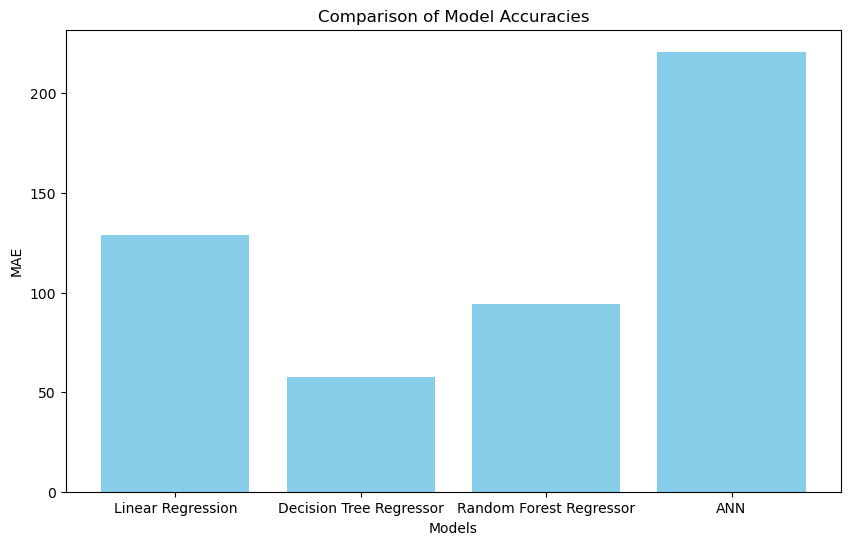

In [34]:
# Plot model accuracies
plt.figure(figsize=(10, 6))
plt.bar(model_results.keys(), [v["MAE"] for v in model_results.values()], color='skyblue')
plt.xlabel("Models")
plt.ylabel("MAE")
plt.title("Comparison of Model Accuracies")
plt.show()

In [40]:
trained_models = {
    "Linear Regression": models["Linear Regression"],
    "Decision Tree Regressor": models["Decision Tree Regressor"],
    "Random Forest Regressor": models["Random Forest Regressor"],
    "KNN Regressor": models["KNN Regressor"],
    "ANN": ann_model
}

In [42]:
# Select and justify the best model
best_model_key = min(model_results, key=lambda k: model_results[k]["MAE"])
best_model = trained_models[best_model_key]

# Print the best model and its performance
print(f"The best model is {best_model_key} with an MAE of {model_results[best_model_key]['MAE']:.4f}.")

The best model is Decision Tree Regressor with an MAE of 57.3500.


In [44]:
# Step 2: Prepare future data for prediction
time_difference = 30  # Days in the next month

In [71]:
fuel_budget_data = []

for _, row in fuel_efficiency_by_type.iterrows():
    car = row['Car']
    fuel = row['Fuel Used']
    total_distance = row['total_distance']
    avg_efficiency = row['avg_efficiency']
    
    # Encode categorical variables
    feature_vector_dict = default_feature_vector.copy()
    feature_vector_dict[f'Car_{car}'] = 1  # Set the one-hot column for car
    feature_vector_dict[f'Fuel Used_{fuel}'] = 1  # Set the one-hot column for fuel
    
    # Add numerical features
    feature_vector_dict['distance'] = total_distance
    feature_vector_dict['avg_efficiency'] = avg_efficiency
    
    # Create a DataFrame and align with training columns
    feature_vector = pd.DataFrame([feature_vector_dict])
    feature_vector = feature_vector[X_train.columns]  # Match column order

    # Predict distance for the upcoming month
    predicted_distance = best_model.predict(feature_vector)[0]
    
    # Calculate litres needed based on average efficiency
    litres_needed = predicted_distance / avg_efficiency if avg_efficiency > 0 else 0
    
    # Lookup fuel price for the specific fuel type
    fuel_price = latest_fuel_prices.get(fuel, 0)
    
    # Calculate the fuel budget
    fuel_budget = litres_needed * fuel_price
    
    # Store results
    fuel_budget_data.append({
        'Car': car,
        'Fuel Used': fuel,
        'Predicted Distance (KM)': predicted_distance,
        'Litres Needed': litres_needed,
        'Fuel Price (RM/L)': fuel_price,
        'Fuel Budget (RM)': fuel_budget,
    })

In [73]:
# Step 3: Convert to DataFrame
fuel_budget_df = pd.DataFrame(fuel_budget_data)

# Step 4: Display Results
print("\nPredicted Fuel Budget with Average and Predicted Distance:")
print(fuel_budget_df.to_string(index=False)) 


Predicted Fuel Budget with Average and Predicted Distance:
    Car Fuel Used  Predicted Distance (KM)  Litres Needed  Fuel Price (RM/L)  Fuel Budget (RM)
persona        95                   297.25      48.280253               2.05          98.97452
